# Siamese Network with KNN outliers detector
## Run it on Google Colab Pro with high RAM and GPU
### Report [here](https://github.com/AndreaGhiglione/algorithmic-machine-learning/blob/master/Challenges/C2%20-%20Anomaly%20sound%20detection/report.pdf)

In [5]:
!pip install kaggle

# upload kaggle.json from local
from google.colab import files
uploaded = files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download eurecom-aml-2022-challenge-2

!mkdir data
!unzip eurecom-aml-2022-challenge-2.zip -d data

!mv data/dev_data/dev_data/slider/train/train.csv data/
!mv data/eval_data/eval_data/slider/test/test.csv data/
!rm -d data/public
!rm eurecom-aml-2022-challenge-2.zip

In [7]:
!pip install librosa==0.9.1
!pip install pyod

In [1]:
import os
import random
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

In [2]:
dev_data_path =  "data/dev_data/dev_data/slider/train/"
eval_data_path =  "data/eval_data/eval_data/slider/train/"
dev_files = os.listdir(dev_data_path)
eval_files = os.listdir(eval_data_path)
# add root path
dev_files = [dev_data_path + file for file in dev_files]
eval_files = [eval_data_path + file for file in eval_files]
print(f"There are {len(dev_files)} dev train audio")
print(f"There are {len(eval_files)} eval train audio")

# merge in a unique train
train_files = [*dev_files, *eval_files]

# get test set (from training set) - This will be used for assessing performances with AUC score
test_data_path =  "data/dev_data/dev_data/slider/test/"
test_files = os.listdir(test_data_path)
test_files = [test_data_path + file for file in test_files]
print(f"There are {len(test_files)} dev test audio")

# get final test set (the one of the leaderboard)
final_test_data_path =  "data/eval_data/eval_data/slider/test/"
final_test_files = os.listdir(final_test_data_path)
final_test_files = [final_test_data_path + file for file in final_test_files]
print(f"There are {len(final_test_files)} final test audio")

There are 2370 dev train audio
There are 2370 eval train audio
There are 1101 dev test audio
There are 834 final test audio


## Train Data preprocessing

In [3]:
import warnings
# Used to suppress warning caused by deprecated API of NumPy version 1.19 or higher
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

wav_files = np.array([librosa.load(file, sr=None) for file in train_files]) 
sample_rates = np.array(list(map(lambda tup: tup[1], wav_files)))
train_audios = np.array(list(map(lambda tup: tup[0], wav_files)))

wav_files = np.array([librosa.load(file, sr=None) for file in test_files])
sample_rates = np.array(list(map(lambda tup: tup[1], wav_files)))
test_audios = np.array(list(map(lambda tup: tup[0], wav_files)))

wav_files = np.array([librosa.load(file, sr=None) for file in final_test_files])
sample_rates = np.array(list(map(lambda tup: tup[1], wav_files)))
final_test_audios = np.array(list(map(lambda tup: tup[0], wav_files)))

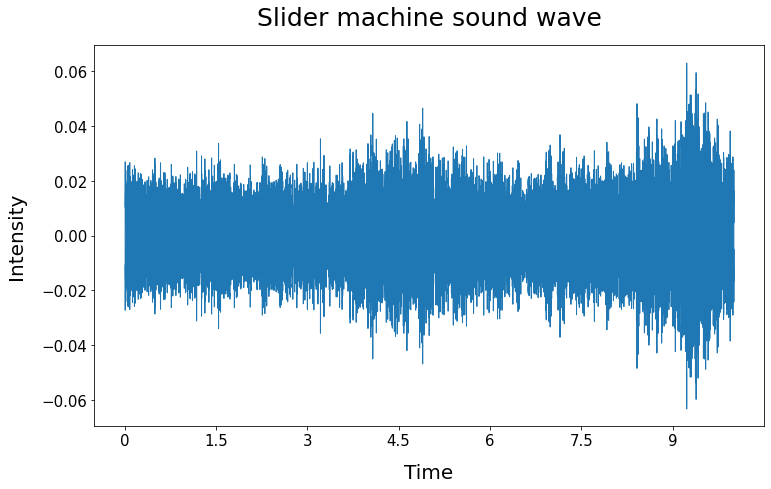

In [4]:
plt.figure(figsize=(12,7))
librosa.display.waveshow(train_audios[9], sr=16000)
plt.title("Slider machine sound wave", fontsize=25, pad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Time", fontsize=20, labelpad=15)
plt.ylabel("Intensity", fontsize=20, labelpad=15)
plt.show()

In [5]:
# get spectrograms
sample_rate = sample_rates[0]

X_train_val = librosa.power_to_db(librosa.feature.melspectrogram(y=train_audios,
                      sr=sample_rate,
                      n_fft=1024,
                      hop_length=417,
                      n_mels=384,
))

X_test = librosa.power_to_db(librosa.feature.melspectrogram(y=test_audios,
                      sr=sample_rate,
                      n_fft=1024,
                      hop_length=417,
                      n_mels=384,
))

X_test_final = librosa.power_to_db(librosa.feature.melspectrogram(y=final_test_audios,
                      sr=sample_rate,
                      n_fft=1024,
                      hop_length=417,
                      n_mels=384,
))

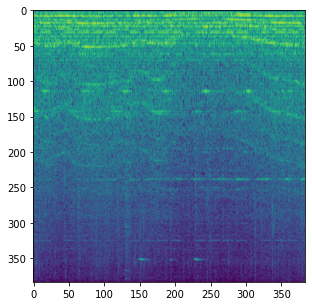

In [6]:
# display a spectrogram
plt.figure(figsize=(15,5))
plt.imshow(X_train_val[0])
plt.show()

In [7]:
# resize image for Siamese Neural Network - 128x128 input for a fast training
from skimage.transform import resize

X_train_val = resize(X_train_val, (X_train_val.shape[0],128,128))
X_test = resize(X_test, (X_test.shape[0],128,128))
X_test_final = resize(X_test_final, (X_test_final.shape[0],128,128))

In [10]:
def get_machine_id_from_file_name(file_name):
    # Siamese Network solves a supervised problem, hence we use machine IDs as labels in the first part of our work
    return int(file_name.split("/")[-1].split("_")[2])

def get_labels(files):
    labels = []
    for file in files:
      labels.append(int(get_machine_id_from_file_name(file)))
    return np.array(labels)

y_train_val = get_labels(train_files)
y_test = get_labels(test_files)

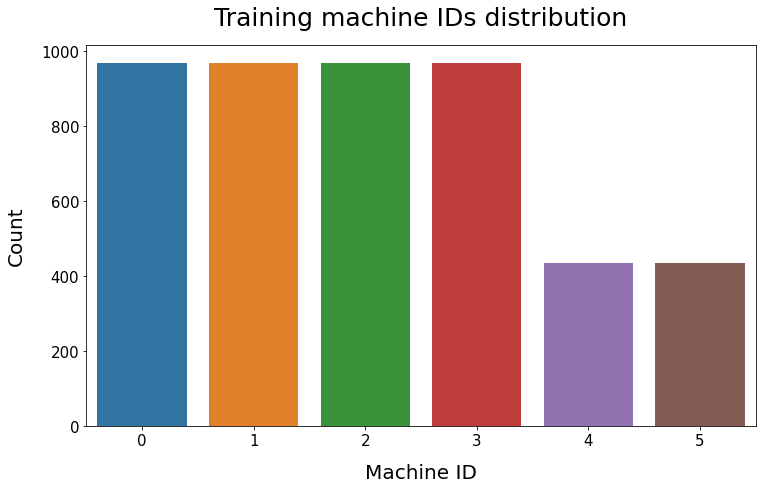

In [11]:
# visualize training slider machine IDs distribution

plt.figure(figsize=(12,7))
sns.countplot(x=y_train_val)
plt.title("Training machine IDs distribution", fontsize=25, pad=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Machine ID", fontsize=20, labelpad=15)
plt.ylabel("Count", fontsize=20, labelpad=15)
plt.show()

In [12]:
# Use 20% of train_val as validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.8, random_state=42, stratify=y_train_val)

In [13]:
# Normalize
def normalize_sample(sample):
    return (sample - sample.mean()) / sample.std()

def norm_set(X):
    for i, element in enumerate(X):
        X[i] = normalize_sample(X[i])
    return X

X_train = norm_set(X_train)
X_val = norm_set(X_val)
X_test = norm_set(X_test)

In [14]:
# Generate pairs for input to Siamese Network. 
# If ID is either 4 or 5 generate double pairs since those are the half of other machine IDs (we balance the sets)
def make_pairs(x, y, test=False):
    # num classes, pay attention to class 0 (Slider machine IDs range from 0 to 5)
    num_classes = max(y) + 1
    # list of ndarrays, each containing the indices of a specific class in the dataset
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add 5 matching examples - if classes 4 or 5 add 10 matching examples
        if idx1 == 4 or idx1 == 5:
            num_pairs = 10
        else:
            num_pairs = 5

        x1 = x[idx1]
        label1 = y[idx1]
        for j in range(num_pairs):
            idx2 = random.choice(digit_indices[label1])
            x2 = x[idx2]
          
            pairs += [[x1, x2]]  # add positive pair
            labels += [1]

        # add 5 non-matching example (or 10 if classes are either 4 or 5)
        for j in range(num_pairs):
            label2 = random.randint(0, num_classes - 1)
            if test:  # in case it is test we have to skip classes 1,3,5 since dev_test contains only 0,2,4 machine IDs
                while label2 == label1 or label2 in [1,3,5]:
                    label2 = random.randint(0, num_classes - 1)
            else:
                while label2 == label1:
                    label2 = random.randint(0, num_classes - 1)

            idx2 = random.choice(digit_indices[label2])
            x2 = x[idx2]

            pairs += [[x1, x2]]  # add negative pair
            labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(X_train, y_train)
# make validation pairs
pairs_val, labels_val = make_pairs(X_val, y_val)
# make test pairs
pairs_test, labels_test = make_pairs(X_test, y_test, test=True)

In [15]:
# Split train, validation and test pairs
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]

In [16]:
# visualize pairs if wanted
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

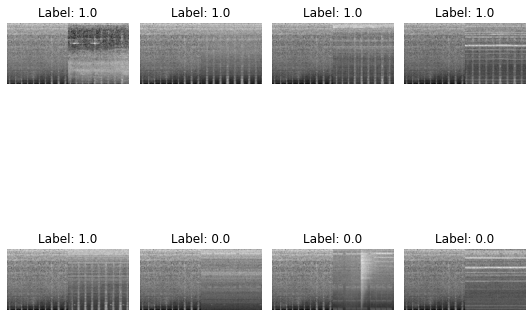

In [17]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=8, num_col=4)

In [22]:
# Siamese Network with euclidean distance
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

# pretty fast network, few layers
input = layers.Input((128, 128, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(64, activation="tanh")(x)  # 64 features that will be used as input to KNN outlier detector
embedding_network = tf.keras.Model(input, x)


input_1 = layers.Input((128, 128, 1))
input_2 = layers.Input((128, 128, 1))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [20]:
def loss(margin=1):
    # contrastive loss with margin 1 by default
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [25]:
opt = SGD(lr=0.05, momentum=0.7)
siamese.compile(loss=loss(margin=1), optimizer=opt, metrics=["accuracy"])
siamese.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 64)           916796      ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [26]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=128,
    epochs=35,
)

Epoch 1/35
297/297 [==============================] - 29s 49ms/step - loss: 0.2438 - accuracy: 0.5614 - val_loss: 0.2288 - val_accuracy: 0.6527
Epoch 2/35
297/297 [==============================] - 12s 40ms/step - loss: 0.2026 - accuracy: 0.6732 - val_loss: 0.2223 - val_accuracy: 0.7256
Epoch 3/35
297/297 [==============================] - 12s 39ms/step - loss: 0.1722 - accuracy: 0.7366 - val_loss: 0.1556 - val_accuracy: 0.7984
Epoch 4/35
297/297 [==============================] - 12s 39ms/step - loss: 0.1397 - accuracy: 0.7954 - val_loss: 0.1317 - val_accuracy: 0.8298
Epoch 5/35
297/297 [==============================] - 12s 39ms/step - loss: 0.1227 - accuracy: 0.8245 - val_loss: 0.1246 - val_accuracy: 0.8396
Epoch 6/35
297/297 [==============================] - 12s 40ms/step - loss: 0.1108 - accuracy: 0.8460 - val_loss: 0.1074 - val_accuracy: 0.8578
Epoch 7/35
297/297 [==============================] - 12s 40ms/step - loss: 0.1011 - accuracy: 0.8602 - val_loss: 0.0983 - val_accuracy:

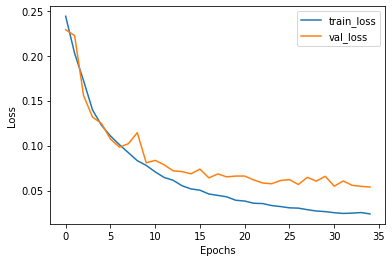

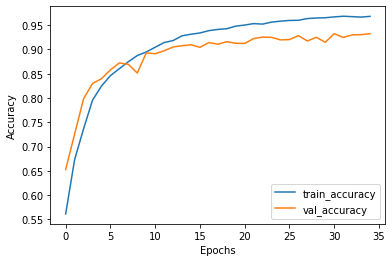

In [27]:
# function to plot history of loss and accuracy - training and validation
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

plot_history(
    history.history["loss"],
    history.history["val_loss"],
    history.history["accuracy"],
    history.history["val_accuracy"],
)

In [28]:
# Extract encoder which is used as feature extractor for the KNN outlier detector
input = layers.Input((128, 128, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(64, activation="tanh")(x)
embedding_network = tf.keras.Model(input, x)

# set weights of the trained Siamese network encoder with weights from training
embedding_network.layers[1].set_weights(siamese.layers[2].get_weights()[:4])  # BN params
embedding_network.layers[2].set_weights(siamese.layers[2].get_weights()[4:6])  # conv2d weights + biases
embedding_network.layers[5].set_weights(siamese.layers[2].get_weights()[6:8])  # conv2d weights + biases
embedding_network.layers[9].set_weights(siamese.layers[2].get_weights()[8:12])  # BN params
embedding_network.layers[10].set_weights(siamese.layers[2].get_weights()[12:])  # Dense matrix + biases

In [29]:
# Now extract features to feed to KNN outliers detector
X_train = np.concatenate((X_train, X_val), axis=0)
feat_vect_train = embedding_network.predict(X_train)
feat_vect_test = embedding_network.predict(X_test)

In [30]:
# If you want to apply PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

sc = StandardScaler()
feat_vect_train_sc = sc.fit_transform(feat_vect_train)
feat_vect_test_sc = sc.transform(feat_vect_test)
pca = PCA(0.7)
feat_vect_train_pca = pca.fit_transform(feat_vect_train_sc)
feat_vect_test_pca = pca.transform(feat_vect_test_sc)

In [31]:
# KNN outliers detector
from pyod.models.knn import KNN

knn = KNN(contamination=0.01)
knn.fit(feat_vect_train_pca)
y_train_scores = knn.decision_scores_

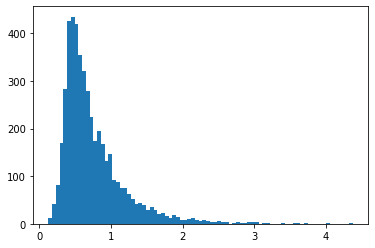

In [32]:
plt.hist(y_train_scores, bins='auto')
plt.show()

In [33]:
# compute AUC score on development test set
from sklearn.metrics import roc_auc_score

# Extract test labels
y_true = []
for file in test_files:
    if "anomaly" in file:
        y_true.append(1)
    else:
        y_true.append(0)
y_true = np.array(y_true)

roc_auc_score(y_true, knn.decision_function(feat_vect_test_pca))

0.946496046608406

In [34]:
# Final test submission
final_test_files = [file.split("/")[-1] for file in final_test_files]
X_test_final = norm_set(X_test_final)
feat_vect_test_final = embedding_network.predict(X_test_final)
anomaly_scores = knn.decision_function(pca.transform(sc.transform(feat_vect_test_final)))
submission_df = pd.DataFrame(data={'file_name': final_test_files,
                                   'anomaly_score': anomaly_scores.squeeze()})
submission_df_sorted = submission_df.sort_values(by="file_name", ignore_index=True)
submission_df_sorted.to_csv("submission.csv", index=False)

In [35]:
submission_df_sorted

,file_name,anomaly_score
0,id_01_00000000.wav,4.476383
1,id_01_00000001.wav,1.744544
2,id_01_00000002.wav,0.649754
3,id_01_00000003.wav,1.936075
4,id_01_00000004.wav,1.199792
...,...,...
829,id_05_00000273.wav,0.544706
830,id_05_00000274.wav,0.785035
831,id_05_00000275.wav,0.435750
832,id_05_00000276.wav,3.316083
